# **Monitoring Activation Stats**

This NB will focus on building functionality to allow the monitoring of activation stats during the modelling process. Thus allowing us to diagnose issues during both training and inference, by actually looking _inside_ the models.

In [1]:
from __future__ import annotations
import random,math,torch
import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [2]:
import torch.nn.functional as F
import matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

To enable reproducibility, especially for the context of modelling on a single machine, we will use PyTorch's `use_deterministic_algorithms` flag.

According to [PyTorch](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch-use-deterministic-algorithms):

> ...algorithms which, given the same input, and when run on the same software and hardware, always produce the same output. When enabled, operations will use deterministic algorithms when available, and if only nondeterministic algorithms are available they will throw a `RuntimeError` when called.

In [3]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

## **Get Data**

In [4]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

## **Create a Baseline Model**

In [5]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

We'll be training at a higher learning rate not only to save time, but also to find a more generalizable set of weights. Jeremy also says that training at a higher learning rate ensures "stable training". **This is something I need to dig into**

In [6]:
from torcheval.metrics import MulticlassAccuracy

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [8]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.162,2.297,0,train
0.293,1.939,0,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


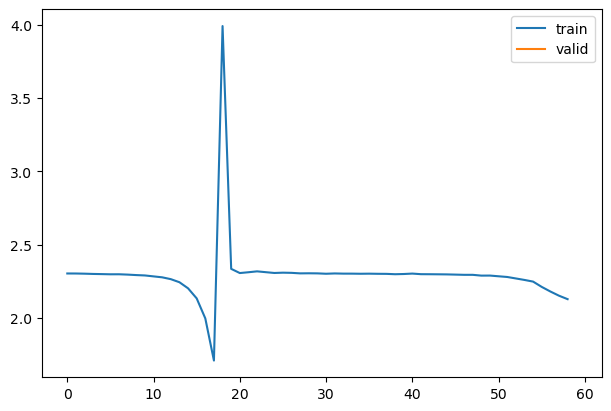

In [9]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

Clearly the model's training process isn't off to a good start. This means there has to be something wrong with our initial activations. Time to build some functionality which allows us to look into the different layers of the model.

## **Using Hooks**

### **Manual Insertion**

In [10]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers) # covered in earlier nbs
        # Taking the means and std of the activations
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.158,2.300,0,train
0.199,2.099,0,eval


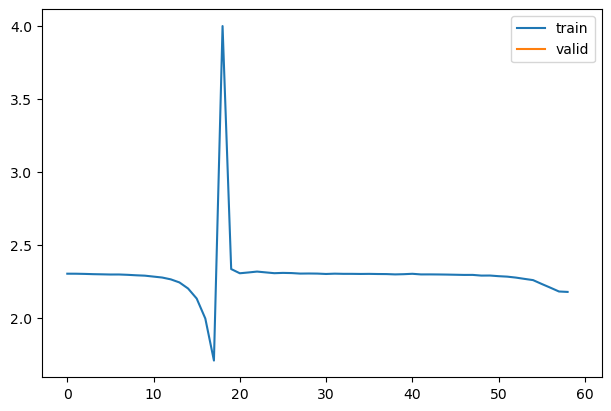

In [11]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

Now we can plot the activation means, for each batch, broken out by individual layers.

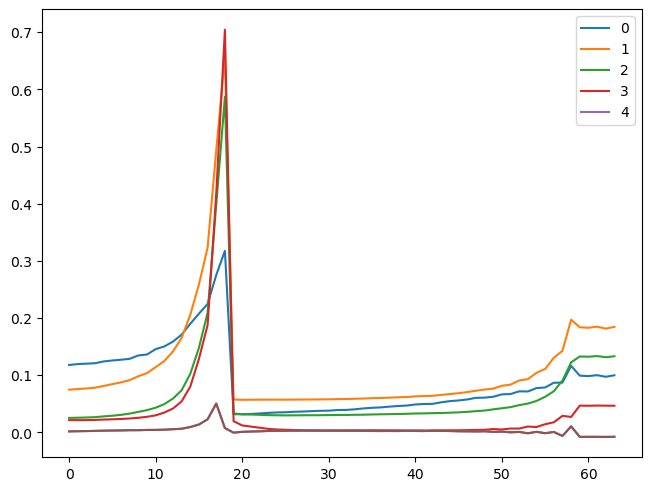

In [12]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

The same for standard deviations.

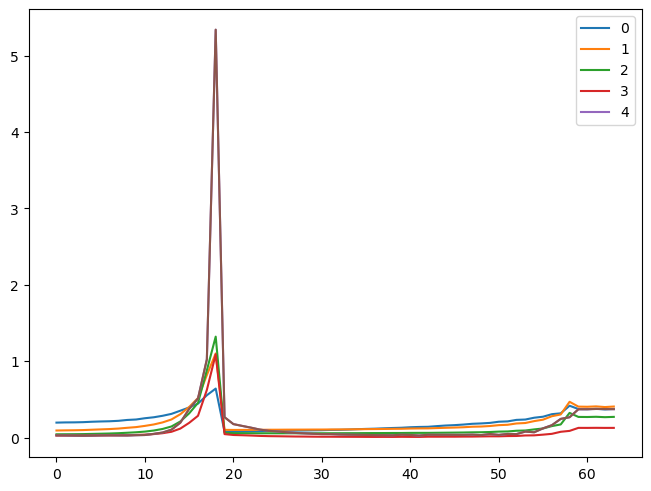

In [13]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

If activations don't follow the general rule of having their means close to 0 and standard deviations close to one - that usually indicates that we have dead neurons with failed activations.

So, our model has failed before it even began to train for increased epochs.

### **PyTorch Hooks**

> Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [14]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We will still need to track the activations means and standard deviations. Since the hook is attached to a layer and takes three arguments, i.e. module, input, output, we will need to store the mean and std of the _output_ in the correct position of our list.

In [15]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [16]:
def append_stats(i, mod, inp, outp): # Function called by the hook, where i is the layer number
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

In [17]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.160,2.300,0,train
0.199,2.111,0,eval


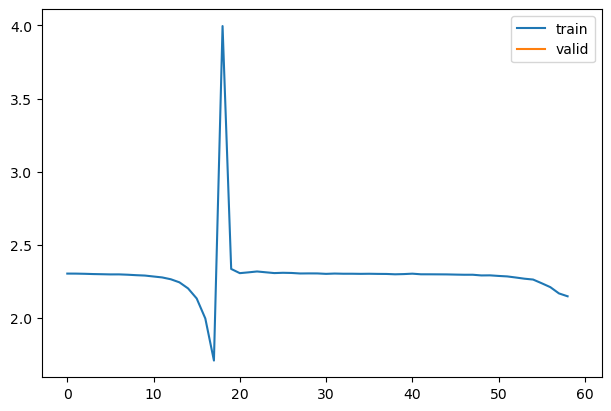

In [18]:
fit(model)

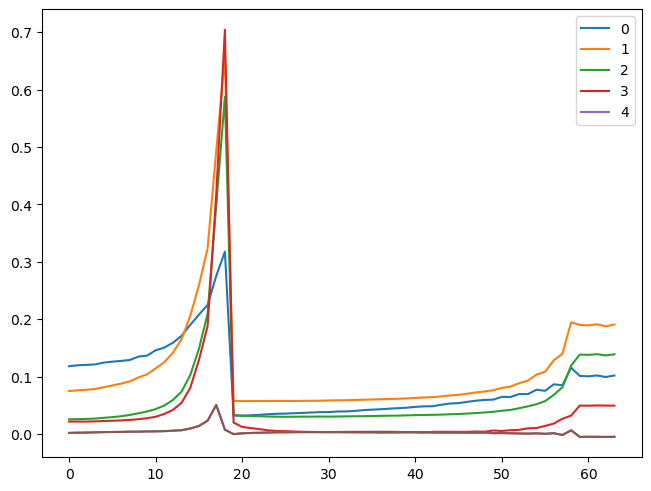

In [19]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### **Refactored Hook Class**

> It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [20]:
class Hook(): # Ensuring that hooks and their references are deleted 
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self)) # Forward pass only

    def remove(self): self.hook.remove() #Free hook object

    def __del__(self): self.remove() #Delete hook object

In [21]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[]) # create stats if they don't exist.
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [22]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [23]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.162,2.296,0,train
0.267,1.970,0,eval


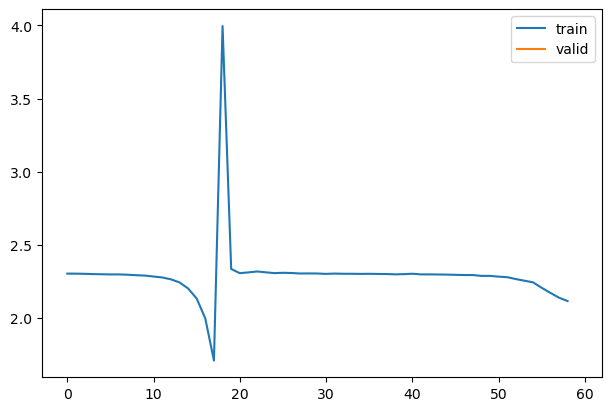

In [24]:
learn = fit(model)

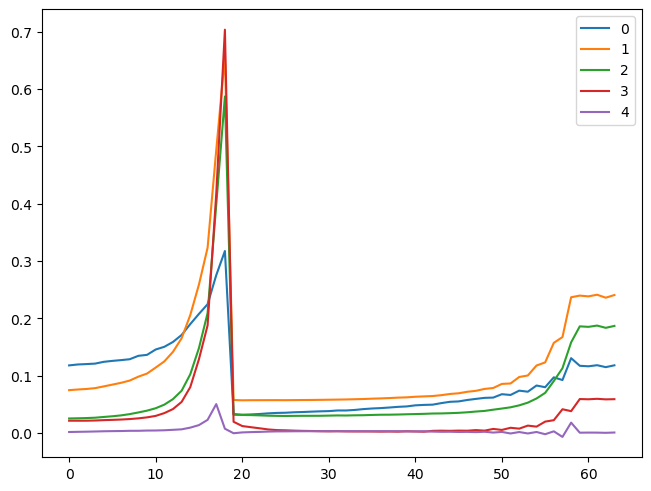

In [25]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

### **A Convenient Hooks Class**
#### **Demo**

We can create our own context managers and also modify how base Python works!!

In [26]:
# for demo purposes
class DummyCtxMgr():
    def __enter__(self, *args):
        print("Starting Up!")
        return self
    
    def __exit__(self, *args): print("Wrapping up!")

    def hello(self): print("Ola!")

In [27]:
with DummyCtxMgr() as dcm: dcm.hello()

Starting Up!
Ola!
Wrapping up!


In [28]:
# Still for demos
class DummyList(list):
    def __delitem__(self, i): # Redefine how __delitem__() works 
        print(f"Dropping item {i}") # Call list
        super().__delitem__(i) # Drop and return updated list

In [29]:
dml = DummyList([1, 3, 2])
dml

[1, 3, 2]

In [30]:
# Delete item by index
del(dml[1])
dml

Dropping item 1


[1, 2]

#### **Custom Hooks Class**

We can create a handy context manager to handle operations linked to Hooks.

In [31]:
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms]) # Inherits from the list

    def __enter__(self, *args): return self # Called when "with" statement is used, returns just the object itself

    def __exit__(self, *args): self.remove() # Called at the end of the block

    def __del__(self): self.remove()

    def __delitem__(self, i): # Can delete single hook from the list
        self[i].remove()
        super().__delitem__(i)

    def remove(self):
        for h in self: h.remove()

In [32]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.158,2.300,0,train
0.199,2.111,0,eval


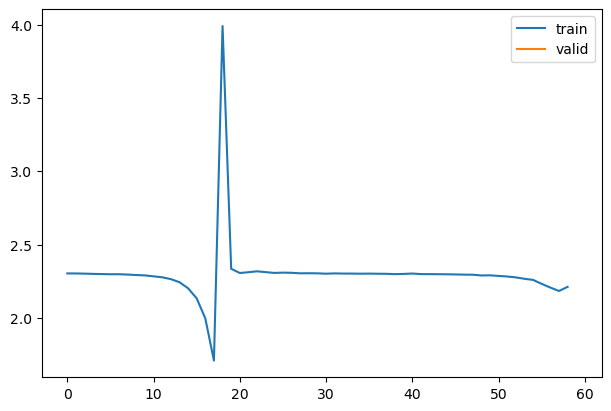

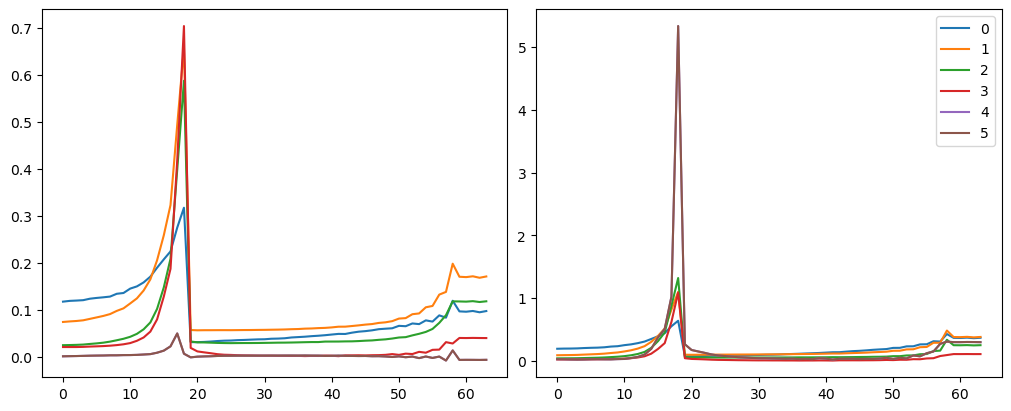

In [33]:
# Hooks() will act as a context manager
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        for i in 0, 1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### **HooksCallback**

In [34]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods: mods = self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()

    def __iter__(self): return iter(self.hooks)

    def __len__(self): return len(self.hooks)

In [35]:
?fc.noop

Signature: fc.noop(x=None, *args, **kwargs)
Docstring: Do nothing
File:      ~/miniforge3/envs/miniai/lib/python3.11/site-packages/fastcore/imports.py
Type:      function

In [36]:
??fc.filter_ex

Signature:
fc.filter_ex(
    iterable,
    f=<function noop at 0x7f0c0f5a7f60>,
    negate=False,
    gen=False,
    **kwargs,
)
Source:   
def filter_ex(iterable, f=noop, negate=False, gen=False, **kwargs):
    "Like `filter`, but passing `kwargs` to `f`, defaulting `f` to `noop`, and adding `negate` and `gen`"
    if f is None: f = lambda _: True
    if kwargs: f = partial(f,**kwargs)
    if negate: f = not_(f)
    res = filter(f, iterable)
    if gen: return res
    return list(res)
File:      ~/miniforge3/envs/miniai/lib/python3.11/site-packages/fastcore/basics.py
Type:      function

In [37]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.159,2.297,0,train
0.316,1.904,0,eval


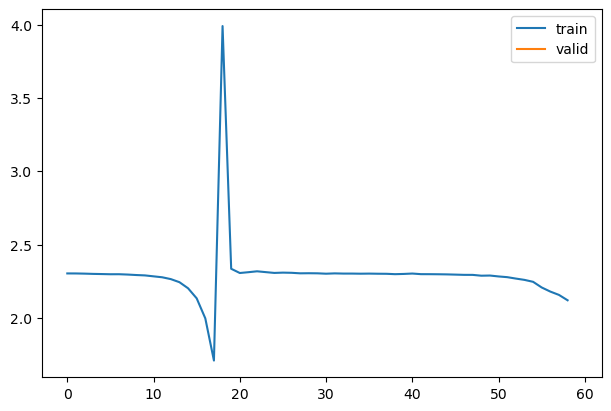

In [38]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

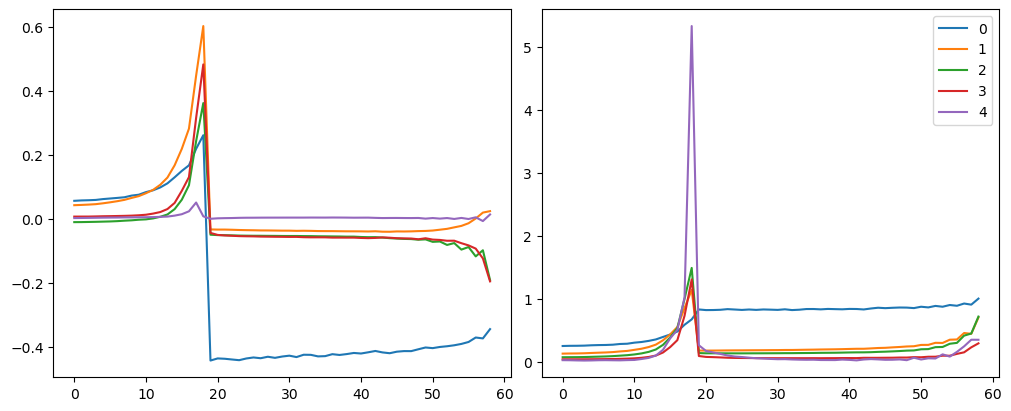

In [39]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

### **Histograms Viz for Layerwise Activations**

In [40]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

accuracy,loss,epoch,train
0.157,2.301,0,train
0.199,2.142,0,eval


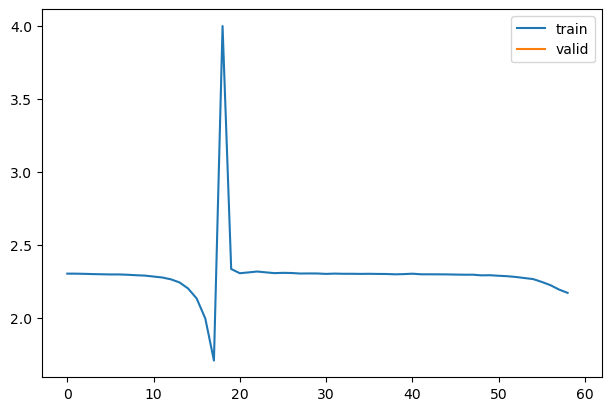

In [41]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

fit(model, xtra_cbs=[hc]);

In [42]:
# Get histogram
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

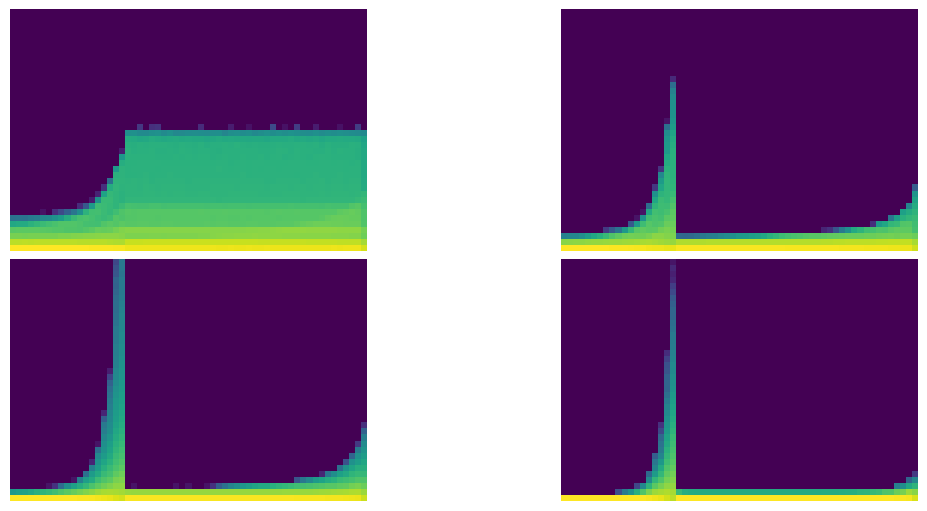

In [43]:
fig, axes = get_grid(len(hc), figsize=(11, 5))

for ax, h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

We also need to be able to visualize the number of dead neurons or failed activations within each layer to complement the histogram view above. The following function does exactly that.

In [44]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    # Take the ratio of the bottom group with the total to get magnitudes
    return h1[0]/h1.sum(0) 

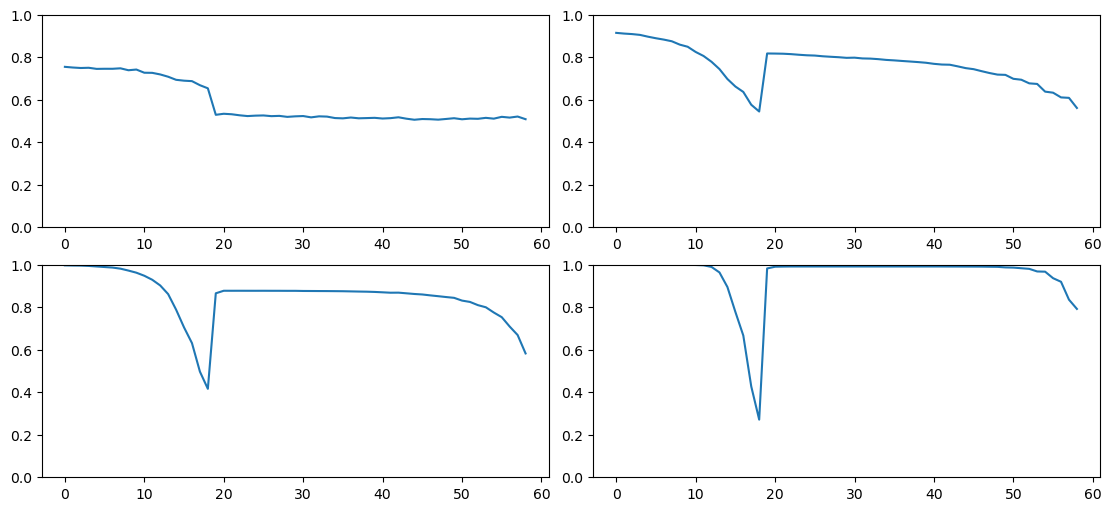

In [45]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## **Composite ActivationStats**

In [46]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0, 1)

    def plot_stats(self, figsize=(10, 4)):
        fig, axs = plt.subplots(1, 2, figsize=figsize)
        for h in self:
            for i in 0, 1: axs[i].plot(h.stats[i])
            axs[0].set_title('Means')
            axs[1].set_title('Stdevs')
            plt.legend(fc.L.range(self))

In [47]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.157,2.295,0,train
0.395,2.286,0,eval


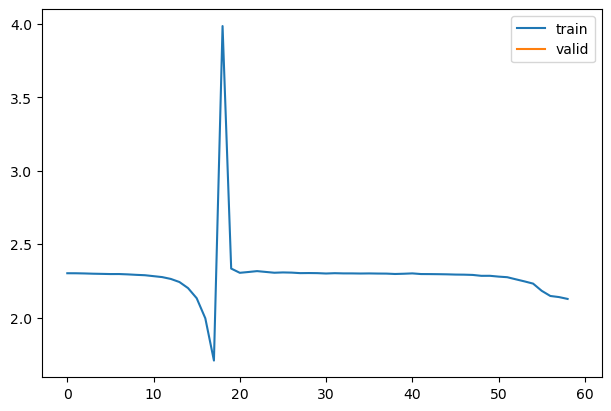

In [48]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

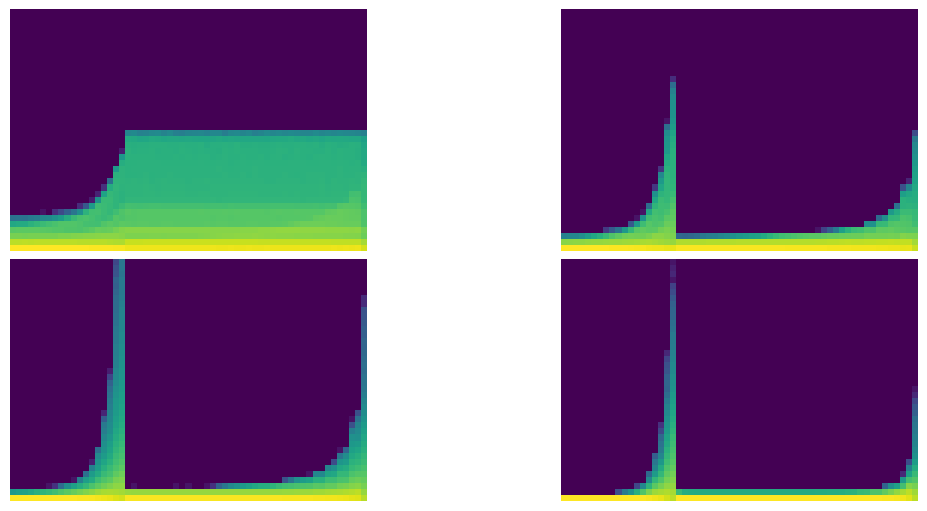

In [49]:
astats.color_dim();

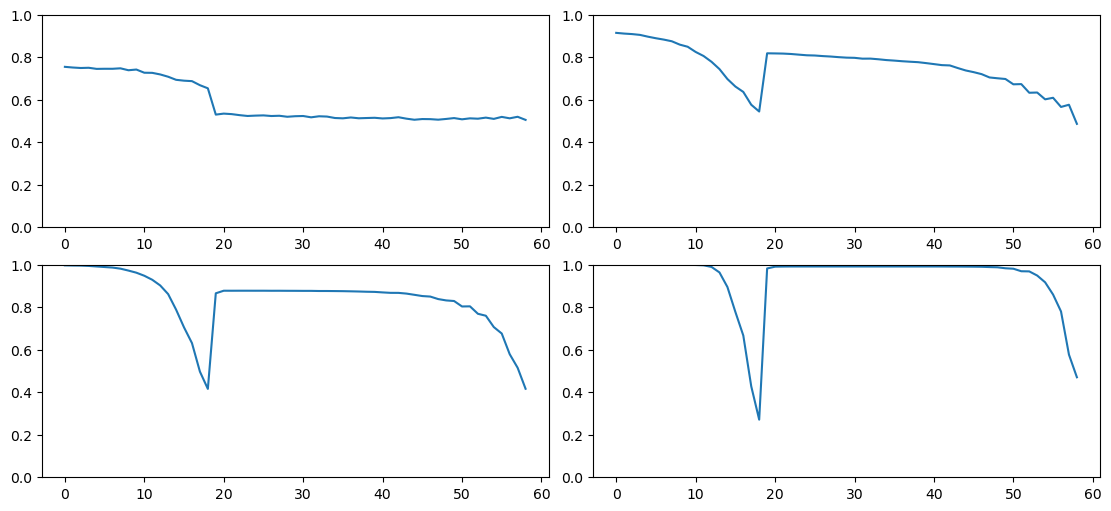

In [50]:
astats.dead_chart();

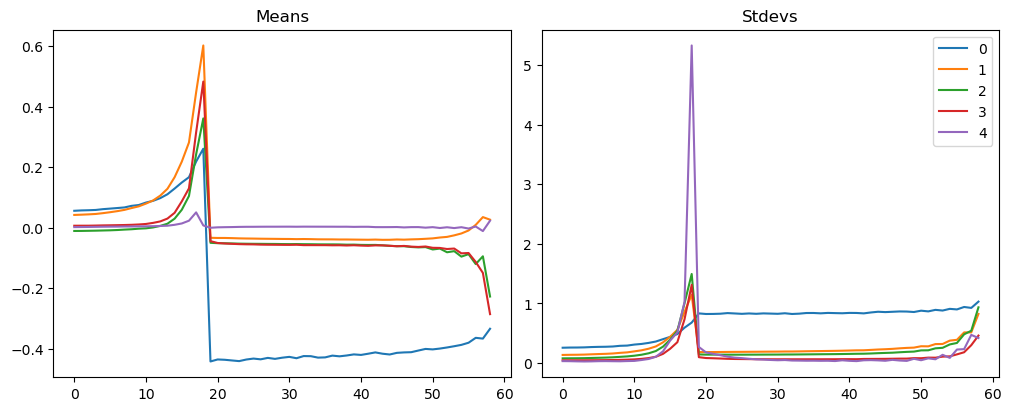

In [51]:
astats.plot_stats();